# **Ouroboros fMRI: Predicting human brain activity with machine learning models**

#### Version: 10th March 2021

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

The first version of this project (17th February 2021) was presented as a Capstone Project for the COS in Applied Data Science: Machine Learning of the EPFL Extension School (https://www.extensionschool.ch/).

==============================================================================================

This project is presented through six Notebooks:

*01: Data Analysis*

***02: Classification* (all classification models except neural networks)**

*03: Neural Networks*

*04: Regression*

*05: Results*

*06: Complements*

==============================================================================================

### Notebook 02

# **Classification**

## **1. Introduction to Classification**

### 1.1 Objective

The objective of this project is to address the general question: **Can we train machine learning models to recognize and predict brain activity?** This problem can be seen both as a classification and a regression challenge. 

As a classification challenge, the specific question can be defined this way: **After training classification models on a set of statistical maps associated with specific conditions, can we accurately classify a set of new, unseen and unlabelled statistical maps?** In our case, the conditions of interest are the 3 levels of 'goal conduciveness', and the target variable can take 3 possible values: good, neutral, bad. Therefore, our approach will be to fit a series of classification models on a train set of statistical maps, each map associated with one of the 3 possible target values, and then to use these models to classify a test set of new, unseen and unlabelled statistical maps. Then, we will verify how often the models have correctly classified the new statistical maps, compared to the level of chance, which is 33% since we have 3 equally distributed possible target values. 

### 1.2 Models

We will use a variety of classification models and fine-tune their hyperparameters when relevant: **k-NN**, **decision tree**, **random forest**, **SVM**, **logistic regression**, **dense neural network**, **convolutional neural network**. This Notebook is dedicated to all classification models except the neural networks, while the next Notebook is dedicated to neural networks exclusively. By default, we will fit the models using the statistical maps with the original voxel size, but if the computations are too heavy, the stastistical maps with the rescaled voxel sizes can also be selected in the data import section. 

### 1.3 Summary

Here is a summary of the features and target variables in classification models and regression models: 

Classification models  | Regression models
------------- | -------------
*Features*: statistical maps  | *Features:* value of all voxels/clusters except the voxel/cluster of interest
*Target*: condition of interest (good, neutral, bad)  | *Target:* value of the voxel/cluster of interest

And here is a general overview of the major preprocessing, model training, model testing and model comparison steps in this project:

Classification models (except neural networks)  | Classification models (neural networks)  | Regression models
------------- | ------------- | -------------
Rescale voxel size: optional  | Rescale voxel size: optional  | Rescale voxel size: optional
Split into train+valid (X) and test (X_te) sets  | Split into train+valid (X) and test (X_te) sets  | Split into train+valid (X) and test (X_te) sets
Flatten the arrays  | Keep the 3D arrays  |  Flatten the arrays
Remove NaN or replace by zero  | Replace NaN by zero | Remove NaN or replace by zero
Fine tuning: grid search with cross-validation  | Neural network training  | Fine tuning: split train+valid (X) into X_tr and X_va
Model comparison: test accuracy  | Model comparison: test accuracy  | Model comparison: MSE
Baseline: level of chance (33%)  | Baseline: level of chance (33%)  | Baseline: mean value of the voxel/cluster obtained from train set

## **2. Rules and functions**

In order to fine-tune our classification models, we will use a **grid search with cross-validation** strategy, with a 5-fold cross-validation. Since we work with a limited number of statistical maps, we will not always end up with one single best combination of hyperparameters. Sometimes, several combinations will show the maximum mean test score, and we should specify a **set of rules** to decide which hyperparameters to choose in this scenario. 

We will use the following set of rules, which seem reasonable: 1) When a parameter ranges clearly from simple to complex, for example the depth of a decision tree or the number of estimators in a random forest, **we take the simplest one as the optimal parameter**. 2) When a parameter refers to a general strategy, for example RBF vs linear kernel in SVM, or OVR vs multinomial strategy in logistic regression, **we take the strategy that shows the highest mean test score as the optimal parameter**. 3) When one of the best values is the default value of a parameter, for example C = 1 for SVM or logistic regression, **we take this default value as the optimal parameter**. 4) If the application of these rules remains insufficient to select a single solution, **we take the first of the remaining results**. Of course, if the grid search with cross-validation allows us to identify a clear winner, none of these rules apply and we take simply the combination of hyperparameters with the maximum mean test score. 

In the following cells, we define a series of functions that will be helpful throughout the Notebook to **display the results from our grid searches with DataFrames and graphs**, and to compute **confusion matrixes** to visualize the accuracy of our predictions. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

In [2]:
# Define a function to display the grid search results with a DataFrame. 
def train_valid_dataframe(grid_cv, model_name, parameter_name, second_parameter_name = '', third_parameter_name = ''):
    cols = ['param_' + model_name + '__' + parameter_name, 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']
    if second_parameter_name != '':
        cols = ['param_' + model_name + '__' + second_parameter_name] + cols
    if third_parameter_name != '':
        cols = ['param_' + model_name + '__' + third_parameter_name] + cols
    cv_results = pd.DataFrame(grid_cv.cv_results_)[cols]
    return cv_results

In [3]:
# Define a function to display the grid search results with a graph. 
def train_valid_graph(plot_results, model_name, parameter_name):
    plot_grid_parameter = eval('cv_results_' + model_name + '.param_' + model_name + '__' + parameter_name + '.values.astype(int)')
    
    # Plot the mean scores. 
    plt.plot(plot_grid_parameter, plot_results.mean_train_score, label = 'train', color = 'blue')
    plt.plot(plot_grid_parameter, plot_results.mean_test_score, label = 'test', color = 'green')

    # Plot the variance area. 
    plt.fill_between(plot_grid_parameter, 
                     plot_results.mean_train_score - plot_results.std_train_score,
                     plot_results.mean_train_score + plot_results.std_train_score,
                     alpha = 0.2, color = 'blue')
    plt.fill_between(plot_grid_parameter, 
                     plot_results.mean_test_score - plot_results.std_test_score,
                     plot_results.mean_test_score + plot_results.std_test_score,
                     alpha = 0.2, color = 'green');

    # Add marker for the best score. 
    idx_best_parameter = plot_results.mean_test_score.idxmax()
    plt.scatter(plot_grid_parameter[idx_best_parameter], plot_results.mean_test_score.max(), marker = 'x', c = 'green', zorder = 10)

    # Display title and labels. 
    plt.title('Optimal {}: {} with {:.1f}% accuracy'.format(parameter_name, plot_grid_parameter[idx_best_parameter], 100 * plot_results.mean_test_score[idx_best_parameter]))
    plt.ylabel('Accuracy')
    plt.xlabel(parameter_name)
    plt.xticks(plot_grid_parameter)
    plt.legend()
    plt.show();

In [4]:
# Define a function to generate a Scikit-learn confusion matrix. 
def scikit_learn_confusion_matrix(y_te, y_pred):
    # Compute the confusion matrix. 
    labels = ['good', 'neutral', 'bad']
    matrix = confusion_matrix(
        y_true = y_te,
        y_pred = y_pred, 
        labels = labels
    )

    # Return confusion matrix as a DataFrame. 
    matrix_df = pd.DataFrame(data = matrix, columns = labels, index = labels)
    matrix_df.columns.name = 'Predictions'
    matrix_df.index.name = 'True class'
    return matrix_df

In [5]:
# Define a function to generate a custom confusion matrix. 
def custom_confusion_matrix(y_te, y_pred):
    # Compute the confusion matrix. 
    pred_comparison = pd.DataFrame([y_te, y_pred], index = ['y_te', 'y_pred']).T
    labels = ['good', 'neutral', 'bad']
    matrix_df = pd.DataFrame()
    for y_te_value in labels:
        for y_pred_value in labels:
            matrix_df.loc[y_te_value, y_pred_value] = np.sum((pred_comparison.y_te == y_te_value) & 
                                                             (pred_comparison.y_pred == y_pred_value))

    # Return confusion matrix as a DataFrame. 
    matrix_df.columns.name = 'Predictions'
    matrix_df.index.name = 'True class'
    return matrix_df.astype(int)

## **3. Data import**

In [6]:
# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_fmri_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

In [7]:
# Select rescale mode. 
# 1: original data | 2, 3, 4: voxel size rescaled by a factor 2, 3 or 4. 
rescale_mode = 1

In [8]:
# Load data. 
with np.load(preprocessed_data_path + 'datasets_for_machine_learning.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())
rescale_modes_list = ['', '_r2', '_r3', '_r4']
    
# Features of the train+valid dataset. 
X = data_dict['features_preprocessed' + rescale_modes_list[rescale_mode - 1] + '_tr']

# Features of the test dataset. 
X_te = data_dict['features_preprocessed' + rescale_modes_list[rescale_mode - 1] + '_te']

# Target variables. 
y = data_dict['target_tr']
y_te = data_dict['target_te']

In [9]:
# Display the size of the arrays. 
print('X:   ', X.shape)
print('X_te:', X_te.shape)
print('y:   ', y.shape)
print('y_te:', y_te.shape)

X:    (120, 256007)
X_te: (36, 256007)
y:    (120,)
y_te: (36,)


## **4. K-Nearest Neighbors (k-NN)**

In the following cells, we **fine-tune, fit and compute predictions from a k-NN model**. 

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

### 4.1 Grid search with cross-validation

In [11]:
# Define the set of values to explore. 
k_values = np.arange(1, 17, 1)
k_values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [12]:
# Create pipeline. 
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Create cross-validation object. 
grid_knn = {
    'knn__n_neighbors': k_values
}
grid_cv_knn = GridSearchCV(pipe_knn, grid_knn, cv = 5, return_train_score = True, verbose = 1, n_jobs = -1)

# Fit k-NN. 
grid_cv_knn.fit(X, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [13]:
# Display the results with a DataFrame. 
cv_results_knn = train_valid_dataframe(grid_cv_knn, 'knn', 'n_neighbors')
cv_results_knn

,param_knn__n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score
0,1,1.000000,0.000000,0.408333,0.061237
1,2,0.935417,0.017922,0.441667,0.122474
2,3,0.925000,0.012148,0.466667,0.061237
3,4,0.650000,0.016925,0.441667,0.097183
4,5,0.552083,0.018634,0.533333,0.061237
5,6,0.333333,0.000000,0.483333,0.033333
6,7,0.389583,0.031319,0.466667,0.066667
7,8,0.404167,0.046304,0.450000,0.121906
8,9,0.416667,0.040612,0.475000,0.062361
9,10,0.466667,0.017922,0.500000,0.069722


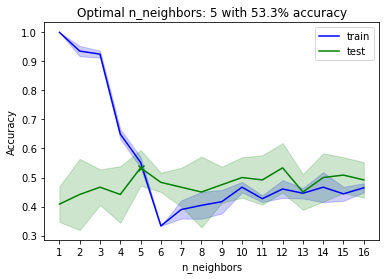

In [14]:
# Display the results with a graph and mark the first best result. 
train_valid_graph(cv_results_knn, 'knn', 'n_neighbors')

### 4.2 Test score with optimal parameters

In [15]:
# Select the results with the highest mean test score. 
best_results_knn = cv_results_knn[cv_results_knn.mean_test_score == cv_results_knn.mean_test_score.max()]
best_results_knn

,param_knn__n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score
4,5,0.552083,0.018634,0.533333,0.061237
11,12,0.460417,0.030477,0.533333,0.084984


In [16]:
# Among these results, select the result with the lowest number of neighbors. 
best_result_knn = best_results_knn[best_results_knn.param_knn__n_neighbors == best_results_knn.param_knn__n_neighbors.min()]
best_result_knn

,param_knn__n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score
4,5,0.552083,0.018634,0.533333,0.061237


In [17]:
# Get this number of neighbors. 
best_param_knn = best_result_knn.param_knn__n_neighbors.iloc[0]
best_param_knn

5

In [18]:
# Create pipeline. 
pipe_knn_optimal = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors = best_param_knn))
])

# Fit optimal k-NN. 
pipe_knn_optimal.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])

In [19]:
# Compute and display the test score. 
test_score_knn = pipe_knn_optimal.score(X_te, y_te)
test_score_knn

0.4444444444444444

### 4.3 Predictions and confusion matrix

In [20]:
# Compute and display the predictions. 
y_pred_knn = pipe_knn_optimal.predict(X_te)
y_pred_knn

array(['bad', 'bad', 'neutral', 'neutral', 'bad', 'neutral', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'neutral', 'good',
       'good', 'neutral', 'bad', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'bad', 'good', 'good', 'bad', 'bad', 'good',
       'good', 'good', 'good', 'bad', 'bad'], dtype='<U7')

In [21]:
# Compare the true and predicted target values. 
pred_comparison = pd.DataFrame([y_te, y_pred_knn], index = ['y_te', 'y_pred_knn']).T
pred_comparison.T

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
y_te,good,good,neutral,neutral,bad,bad,good,good,neutral,neutral,...,neutral,neutral,bad,bad,good,good,neutral,neutral,bad,bad
y_pred_knn,bad,bad,neutral,neutral,bad,neutral,good,good,good,good,...,good,good,bad,bad,good,good,good,good,bad,bad


In [22]:
# Display a Scikit-learn confusion matrix. 
confusion_matrix_knn = scikit_learn_confusion_matrix(y_te, y_pred_knn)
confusion_matrix_knn

Predictions,good,neutral,bad
True class,,,
good,8,1,3
neutral,10,2,0
bad,4,2,6


In [23]:
# Security check: display a custom confusion matrix. 
custom_confusion_matrix_knn = custom_confusion_matrix(y_te, y_pred_knn)
custom_confusion_matrix_knn

Predictions,good,neutral,bad
True class,,,
good,8,1,3
neutral,10,2,0
bad,4,2,6


In [24]:
# Verify if the two confusion matrixes are equal. 
confusion_matrix_knn.equals(custom_confusion_matrix_knn)

True

**Result:** The k-NN model performs better than the baseline of 33%. 

## **5. Decision tree**

In the following cells, we **fine-tune, fit and compute predictions from a decision tree model**. 

In [25]:
from sklearn.tree import DecisionTreeClassifier

### 5.1 Grid search with cross-validation

In [26]:
# Define the set of values to explore. 
n_values = np.arange(1, 11, 1)
n_values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [27]:
# Create pipeline. 
pipe_dt = Pipeline([
    ('scaler', None),
    ('dt', DecisionTreeClassifier(criterion = 'gini', random_state = 0))
])

# Create cross-validation object. 
grid_dt = {
    'dt__max_depth': n_values
}
grid_cv_dt = GridSearchCV(pipe_dt, grid_dt, cv = 5, return_train_score = True, verbose = 1, n_jobs = -1)

# Fit decision tree. 
grid_cv_dt.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'dt__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [28]:
# Display the results with a DataFrame. 
cv_results_dt = train_valid_dataframe(grid_cv_dt, 'dt', 'max_depth')
cv_results_dt

,param_dt__max_depth,mean_train_score,std_train_score,mean_test_score,std_test_score
0,1,0.575000,0.012148,0.508333,0.080795
1,2,0.783333,0.012148,0.508333,0.121906
2,3,0.920833,0.016925,0.508333,0.124722
3,4,0.983333,0.014130,0.516667,0.077280
4,5,1.000000,0.000000,0.466667,0.096465
5,6,1.000000,0.000000,0.466667,0.096465
6,7,1.000000,0.000000,0.466667,0.096465
7,8,1.000000,0.000000,0.466667,0.096465
8,9,1.000000,0.000000,0.466667,0.096465
9,10,1.000000,0.000000,0.466667,0.096465


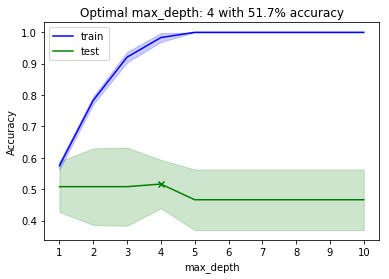

In [29]:
# Display the results with a graph and mark the first best result. 
train_valid_graph(cv_results_dt, 'dt', 'max_depth')

### 5.2 Test score with optimal parameters

In [30]:
# Select the results with the highest mean test score. 
best_results_dt = cv_results_dt[cv_results_dt.mean_test_score == cv_results_dt.mean_test_score.max()]
best_results_dt

,param_dt__max_depth,mean_train_score,std_train_score,mean_test_score,std_test_score
3,4,0.983333,0.01413,0.516667,0.07728


In [31]:
# Among these results, select the result with the lowest tree depth. 
best_result_dt = best_results_dt[best_results_dt.param_dt__max_depth == best_results_dt.param_dt__max_depth.min()]
best_result_dt

,param_dt__max_depth,mean_train_score,std_train_score,mean_test_score,std_test_score
3,4,0.983333,0.01413,0.516667,0.07728


In [32]:
# Get this tree depth. 
best_param_dt = best_result_dt.param_dt__max_depth.iloc[0]
best_param_dt

4

In [33]:
# Create pipeline. 
pipe_dt_optimal = Pipeline([
    ('scaler', None),
    ('dt', DecisionTreeClassifier(max_depth = best_param_dt, criterion = 'gini', random_state = 0))
])

# Fit optimal decision tree. 
pipe_dt_optimal.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', None), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))])

In [34]:
# Compute and display the test score. 
test_score_dt = pipe_dt_optimal.score(X_te, y_te)
test_score_dt

0.5555555555555556

### 5.3 Predictions and confusion matrix

In [35]:
# Compute and display the predictions. 
y_pred_dt = pipe_dt_optimal.predict(X_te)
y_pred_dt

array(['good', 'bad', 'neutral', 'neutral', 'bad', 'bad', 'good', 'good',
       'good', 'good', 'good', 'good', 'neutral', 'neutral', 'neutral',
       'neutral', 'bad', 'bad', 'good', 'good', 'bad', 'bad', 'bad',
       'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'neutral', 'good',
       'neutral', 'neutral', 'good', 'good'], dtype='<U7')

In [36]:
# Compare the true and predicted target values. 
pred_comparison = pd.DataFrame([y_te, y_pred_dt], index = ['y_te', 'y_pred_dt']).T
pred_comparison.T

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
y_te,good,good,neutral,neutral,bad,bad,good,good,neutral,neutral,...,neutral,neutral,bad,bad,good,good,neutral,neutral,bad,bad
y_pred_dt,good,bad,neutral,neutral,bad,bad,good,good,good,good,...,bad,bad,bad,bad,neutral,good,neutral,neutral,good,good


In [37]:
# Display a Scikit-learn confusion matrix. 
confusion_matrix_dt = scikit_learn_confusion_matrix(y_te, y_pred_dt)
confusion_matrix_dt

Predictions,good,neutral,bad
True class,,,
good,6,3,3
neutral,2,6,4
bad,4,0,8


**Result:** The decision tree model performs better than the baseline of 33%. 

## **6. Random forest**

In the following cells, we **fine-tune, fit and compute predictions from a random forest model**. In order to fit the model, we must define the 'max_depth' parameter, corresponding to the maximum depth of each decision tree. We could either select the optimal 'max_depth' value obtained in the previous section for a single decision tree, or use the standard value for this parameter, which is None. Both solutions seem reasonable, but we select the second option in order to separate completely the pipelines of the different models, and allow a more objective comparison of their respective accuracies. 

In [38]:
from sklearn.ensemble import RandomForestClassifier

### 6.1 Grid search with cross-validation

In [39]:
# Define the set of values to explore
n_values = np.arange(5, 105, 5)
n_values

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100])

In [40]:
# Create pipeline. 
pipe_rf = Pipeline([
    ('scaler', None),
    ('rf', RandomForestClassifier(max_depth = None, random_state = 0))
])

# Create cross-validation object. 
grid_rf = {
    'rf__n_estimators': n_values
}
grid_cv_rf = GridSearchCV(pipe_rf, grid_rf, cv = 5, return_train_score = True, verbose = 1, n_jobs = -1)

# Fit random forest. 
grid_cv_rf.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'rf__n_estimators': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [41]:
# Display the results with a DataFrame. 
cv_results_rf = train_valid_dataframe(grid_cv_rf, 'rf', 'n_estimators')
cv_results_rf

,param_rf__n_estimators,mean_train_score,std_train_score,mean_test_score,std_test_score
0,5,0.972917,0.018162,0.425000,0.048591
1,10,0.997917,0.004167,0.466667,0.031180
2,15,1.000000,0.000000,0.525000,0.067700
3,20,1.000000,0.000000,0.541667,0.095015
4,25,1.000000,0.000000,0.558333,0.081650
5,30,1.000000,0.000000,0.541667,0.074536
6,35,1.000000,0.000000,0.566667,0.107367
7,40,1.000000,0.000000,0.575000,0.124722
8,45,1.000000,0.000000,0.591667,0.116070
9,50,1.000000,0.000000,0.566667,0.140929


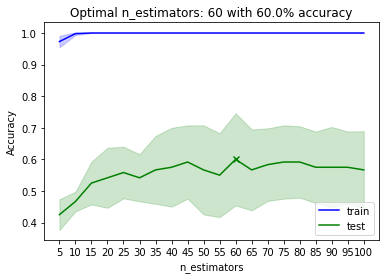

In [42]:
# Display the results with a graph and mark the first best result. 
train_valid_graph(cv_results_rf, 'rf', 'n_estimators')

### 6.2 Test score with optimal parameters

In [43]:
# Select the results with the highest mean test score. 
best_results_rf = cv_results_rf[cv_results_rf.mean_test_score == cv_results_rf.mean_test_score.max()]
best_results_rf

,param_rf__n_estimators,mean_train_score,std_train_score,mean_test_score,std_test_score
11,60,1.0,0.0,0.6,0.145774


In [44]:
# Among these results, select the result with the lowest number of estimators. 
best_result_rf = best_results_rf[best_results_rf.param_rf__n_estimators == best_results_rf.param_rf__n_estimators.min()]
best_result_rf

,param_rf__n_estimators,mean_train_score,std_train_score,mean_test_score,std_test_score
11,60,1.0,0.0,0.6,0.145774


In [45]:
# Get this number of estimators. 
best_param_rf = best_result_rf.param_rf__n_estimators.iloc[0]
best_param_rf

60

In [46]:
# Create pipeline. 
pipe_rf_optimal = Pipeline([
    ('scaler', None),
    ('rf', RandomForestClassifier(n_estimators = best_param_rf, max_depth = None, random_state = 0))
])

# Fit optimal random forest. 
pipe_rf_optimal.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', None), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [47]:
# Compute and display the test score. 
test_score_rf = pipe_rf_optimal.score(X_te, y_te)
test_score_rf

0.6666666666666666

### 6.3 Predictions and confusion matrix

In [48]:
# Compute and display the predictions. 
y_pred_rf = pipe_rf_optimal.predict(X_te)
y_pred_rf

array(['bad', 'bad', 'neutral', 'neutral', 'bad', 'bad', 'neutral',
       'good', 'neutral', 'neutral', 'neutral', 'good', 'neutral',
       'neutral', 'neutral', 'neutral', 'bad', 'bad', 'good', 'good',
       'neutral', 'neutral', 'bad', 'bad', 'neutral', 'bad', 'neutral',
       'neutral', 'bad', 'bad', 'neutral', 'neutral', 'neutral',
       'neutral', 'bad', 'good'], dtype='<U7')

In [49]:
# Compare the true and predicted target values. 
pred_comparison = pd.DataFrame([y_te, y_pred_rf], index = ['y_te', 'y_pred_rf']).T
pred_comparison.T

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
y_te,good,good,neutral,neutral,bad,bad,good,good,neutral,neutral,...,neutral,neutral,bad,bad,good,good,neutral,neutral,bad,bad
y_pred_rf,bad,bad,neutral,neutral,bad,bad,neutral,good,neutral,neutral,...,neutral,neutral,bad,bad,neutral,neutral,neutral,neutral,bad,good


In [50]:
# Display a Scikit-learn confusion matrix. 
confusion_matrix_rf = scikit_learn_confusion_matrix(y_te, y_pred_rf)
confusion_matrix_rf

Predictions,good,neutral,bad
True class,,,
good,3,6,3
neutral,0,12,0
bad,2,1,9


**Result:** The random forest model performs better than the baseline of 33%. 

## **7. Support Vector Machine (SVM)**

In the following cells, we **fine-tune, fit and compute predictions from a SVM model**. In order to fit the model, we must define the 'C' and 'gamma' parameters, which control respectively the complexity of the model and the general behavior of the RBF kernel. For the 'C' parameter, the default value is 1, therefore it seems relevant to explore the parameter space around this value. For the 'gamma' parameter of the RBF kernel, the default value is 'auto', and from the documentation we learn that this value corresponds to 1 / n_features, therefore it seems relevant to compute this value and explore the parameter space around it. 

In [51]:
from sklearn.svm import SVC

### 7.1 Grid search with cross-validation

In [52]:
# Define the set of values to explore for the C parameter. 
c_values = np.logspace(-3, 3, num = 7)
c_values

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [53]:
# Compute and display the 'auto' value for the gamma parameter. 
auto_value = 1 / X.shape[1]
auto_value

3.9061431913971105e-06

In [54]:
# Define the set of values to explore for the gamma parameter. 
rounded_auto_value = 10 ** np.round(np.log10(auto_value))
g_values = ['auto', 
            np.round(0.00001 * rounded_auto_value, decimals = 15),
            np.round(0.0001 * rounded_auto_value, decimals = 15),
            np.round(0.001 * rounded_auto_value, decimals = 15),
            np.round(0.01 * rounded_auto_value, decimals = 15),
            np.round(0.1 * rounded_auto_value, decimals = 15),
            np.round(1 * rounded_auto_value, decimals = 15),
            np.round(10 * rounded_auto_value, decimals = 15),
            np.round(100 * rounded_auto_value, decimals = 15)]
g_values

['auto', 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001]

In [55]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state = 0))
])

# Create cross-validation object. 
grid_svm = [{
        'svm__kernel': ['rbf'],
        'svm__C': c_values,
        'svm__gamma': g_values
    }, {
        'svm__kernel': ['linear'],
        'svm__C': c_values,
        'svm__gamma': ['auto']
    }]
grid_cv_svm = GridSearchCV(pipe_svm, grid_svm, cv = 5, return_train_score = True, verbose = 1, n_jobs = -1)

# Fit SVM. 
grid_cv_svm.fit(X, y)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 18.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'svm__kernel': ['rbf'], 'svm__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'svm__gamma': ['auto', 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001]}, {'svm__kernel': ['linear'], 'svm__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'svm__gamma': ['auto']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [56]:
# Display the results with a DataFrame. 
cv_results_svm = train_valid_dataframe(grid_cv_svm, 'svm', 'gamma', 'C', 'kernel')
cv_results_svm

,param_svm__kernel,param_svm__C,param_svm__gamma,mean_train_score,std_train_score,mean_test_score,std_test_score
0,rbf,0.001,auto,0.733333,0.040931,0.500000,0.091287
1,rbf,0.001,1e-10,0.597917,0.034611,0.566667,0.138444
2,rbf,0.001,1e-09,0.597917,0.034611,0.583333,0.170783
3,rbf,0.001,1e-08,0.597917,0.034611,0.583333,0.170783
4,rbf,0.001,1e-07,0.597917,0.034611,0.583333,0.170783
5,rbf,0.001,1e-06,0.629167,0.032676,0.600000,0.179892
6,rbf,0.001,1e-05,0.991667,0.004167,0.416667,0.114867
7,rbf,0.001,0.0001,1.000000,0.000000,0.333333,0.000000
8,rbf,0.001,0.001,1.000000,0.000000,0.333333,0.000000
9,rbf,0.01,auto,0.733333,0.040931,0.500000,0.091287


### 7.2 Test score with optimal parameters

In [57]:
# Compute the maximum mean test score for the RBF and linear kernels. 
max_rbf = cv_results_svm.loc[cv_results_svm.param_svm__kernel == 'rbf', 'mean_test_score'].max()
max_linear = cv_results_svm.loc[cv_results_svm.param_svm__kernel == 'linear', 'mean_test_score'].max()

# If the kernels have different maximum mean test scores, select the best kernel. 
if max_rbf > max_linear:
    best_kernel = 'rbf'
elif max_rbf < max_linear:
    best_kernel = 'linear'
    
# If both kernels have the same maximum mean test score, compute the average mean test score. 
elif max_rbf == max_linear:
    mean_rbf = cv_results_svm.loc[cv_results_svm.param_svm__kernel == 'rbf', 'mean_test_score'].mean()
    mean_linear = cv_results_svm.loc[cv_results_svm.param_svm__kernel == 'linear', 'mean_test_score'].mean()
    
    # If the kernels have different average mean test scores, select the best kernel. 
    # Otherwise select the RBF kernel, which is the default value for the SVC estimator. 
    if mean_rbf >= mean_linear:
        best_kernel = 'rbf'
    else:
        best_kernel = 'linear'

# Create a new DataFrame containing only the results from the best kernel. 
cv_results_best_kernel_svm = cv_results_svm[cv_results_svm.param_svm__kernel == best_kernel]

# Display the best kernel. 
best_kernel

'rbf'

In [58]:
# Among the results with the best kernel, select the results with the highest mean test score. 
best_results_svm = cv_results_best_kernel_svm[cv_results_best_kernel_svm.mean_test_score == cv_results_best_kernel_svm.mean_test_score.max()]
best_results_svm

,param_svm__kernel,param_svm__C,param_svm__gamma,mean_train_score,std_train_score,mean_test_score,std_test_score
40,rbf,10,1e-07,0.6500,0.028413,0.616667,0.152297
56,rbf,1000,1e-09,0.6500,0.028413,0.616667,0.152297
57,rbf,1000,1e-08,0.9625,0.008333,0.616667,0.121906


In [59]:
# Among these results, if some results show the standard parameter C = 1, select them. 
if np.sum(best_results_svm.param_svm__C == 1) > 0:
    best_results_svm = best_results_svm[best_results_svm.param_svm__C == 1]
best_results_svm

,param_svm__kernel,param_svm__C,param_svm__gamma,mean_train_score,std_train_score,mean_test_score,std_test_score
40,rbf,10,1e-07,0.6500,0.028413,0.616667,0.152297
56,rbf,1000,1e-09,0.6500,0.028413,0.616667,0.152297
57,rbf,1000,1e-08,0.9625,0.008333,0.616667,0.121906


In [60]:
# Among these results, if some results show the standard parameter gamma = 'auto', select them. 
if np.sum(best_results_svm.param_svm__gamma == 'auto') > 0:
    best_results_svm = best_results_svm[best_results_svm.param_svm__gamma == 'auto']
best_results_svm

,param_svm__kernel,param_svm__C,param_svm__gamma,mean_train_score,std_train_score,mean_test_score,std_test_score
40,rbf,10,1e-07,0.6500,0.028413,0.616667,0.152297
56,rbf,1000,1e-09,0.6500,0.028413,0.616667,0.152297
57,rbf,1000,1e-08,0.9625,0.008333,0.616667,0.121906


In [61]:
# Among the remaining results, select the first one. 
best_result_svm = best_results_svm.iloc[0]
best_result_svm

param_svm__kernel          rbf
param_svm__C                10
param_svm__gamma         1e-07
mean_train_score          0.65
std_train_score      0.0284129
mean_test_score       0.616667
std_test_score        0.152297
Name: 40, dtype: object

In [62]:
# Get the parameters of this result. 
best_param_C_svm = best_result_svm.param_svm__C
best_param_gamma_svm = best_result_svm.param_svm__gamma
print('Optimal C:    ', best_param_C_svm)
print('Optimal gamma:', best_param_gamma_svm)

Optimal C:     10.0
Optimal gamma: 1e-07


In [63]:
# Create pipeline. 
pipe_svm_optimal = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel = best_kernel, C = best_param_C_svm, gamma = best_param_gamma_svm, random_state = 0))
])

# Fit optimal SVM. 
pipe_svm_optimal.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-07, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))])

In [64]:
# Compute and display the test score. 
test_score_svm = pipe_svm_optimal.score(X_te, y_te)
test_score_svm

0.6666666666666666

### 7.3 Predictions and confusion matrix

In [65]:
# Compute and display the predictions. 
y_pred_svm = pipe_svm_optimal.predict(X_te)
y_pred_svm

array(['good', 'good', 'neutral', 'good', 'bad', 'bad', 'neutral', 'good',
       'neutral', 'neutral', 'good', 'good', 'neutral', 'neutral',
       'neutral', 'neutral', 'bad', 'bad', 'good', 'good', 'neutral',
       'neutral', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad',
       'neutral', 'good', 'neutral', 'neutral', 'bad', 'good'],
      dtype='<U7')

In [66]:
# Compare the true and predicted target values. 
pred_comparison = pd.DataFrame([y_te, y_pred_svm], index = ['y_te', 'y_pred_svm']).T
pred_comparison.T

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
y_te,good,good,neutral,neutral,bad,bad,good,good,neutral,neutral,...,neutral,neutral,bad,bad,good,good,neutral,neutral,bad,bad
y_pred_svm,good,good,neutral,good,bad,bad,neutral,good,neutral,neutral,...,bad,bad,bad,bad,neutral,good,neutral,neutral,bad,good


In [67]:
# Display a Scikit-learn confusion matrix. 
confusion_matrix_svm = scikit_learn_confusion_matrix(y_te, y_pred_svm)
confusion_matrix_svm

Predictions,good,neutral,bad
True class,,,
good,6,4,2
neutral,1,9,2
bad,3,0,9


**Result:** The SVM model performs better than the baseline of 33%. 

## **8. Logistic regression**

In the following cells, we **fine-tune, fit and compute predictions from a logistic regression model**. 

In [68]:
from sklearn.linear_model import LogisticRegression

### 8.1 Grid search with cross-validation

In [69]:
# Define the set of values to explore. 
c_values = np.logspace(-3, 3, num = 7)
c_values

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [70]:
# Create pipeline. 
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state = 0))
])

# Create cross-validation object. 
grid_logreg = [{
        'logreg__multi_class': ['ovr'],
        'logreg__solver': ['liblinear'],
        'logreg__C': c_values
    }, {
        'logreg__multi_class': ['multinomial'],
        'logreg__solver': ['saga'],
        'logreg__C': c_values
    }]
grid_cv_logreg = GridSearchCV(pipe_logreg, grid_logreg, cv = 5, return_train_score = True, verbose = 1, n_jobs = -1)

# Fit logistic regression. 
grid_cv_logreg.fit(X, y)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 24.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'logreg__multi_class': ['ovr'], 'logreg__solver': ['liblinear'], 'logreg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}, {'logreg__multi_class': ['multinomial'], 'logreg__solver': ['saga'], 'logreg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [71]:
# Display the results with a DataFrame. 
cv_results_logreg = train_valid_dataframe(grid_cv_logreg, 'logreg', 'C', 'multi_class')
cv_results_logreg

,param_logreg__multi_class,param_logreg__C,mean_train_score,std_train_score,mean_test_score,std_test_score
0,ovr,0.001,1.0,0.0,0.558333,0.104083
1,ovr,0.01,1.0,0.0,0.575000,0.106719
2,ovr,0.1,1.0,0.0,0.583333,0.095015
3,ovr,1,1.0,0.0,0.583333,0.095015
4,ovr,10,1.0,0.0,0.575000,0.084984
5,ovr,100,1.0,0.0,0.608333,0.097183
6,ovr,1000,1.0,0.0,0.616667,0.100000
7,multinomial,0.001,1.0,0.0,0.608333,0.119606
8,multinomial,0.01,1.0,0.0,0.616667,0.124722
9,multinomial,0.1,1.0,0.0,0.616667,0.124722


### 8.2 Test score with optimal parameters

In [72]:
# Compute the maximum mean test score for the multinomial and OVR strategies. 
max_multinomial = cv_results_logreg.loc[cv_results_logreg.param_logreg__multi_class == 'multinomial', 'mean_test_score'].max()
max_ovr = cv_results_logreg.loc[cv_results_logreg.param_logreg__multi_class == 'ovr', 'mean_test_score'].max()

# If the strategies have different maximum mean test scores, select the best strategy. 
if max_multinomial > max_ovr:
    best_strategy = 'multinomial'
    best_solver = 'saga'
elif max_multinomial < max_ovr:
    best_strategy = 'ovr'
    best_solver = 'liblinear'

# If both strategies have the same maximum mean test score, compute the average mean test score. 
elif max_multinomial == max_ovr:
    mean_multinomial = cv_results_logreg.loc[cv_results_logreg.param_logreg__multi_class == 'multinomial', 'mean_test_score'].mean()
    mean_ovr = cv_results_logreg.loc[cv_results_logreg.param_logreg__multi_class == 'ovr', 'mean_test_score'].mean()
    
    # If the strategies have different average mean test scores, select the best strategy. 
    # Otherwise select the multinomial strategy, which is the 'auto' value for the LogisticRegression estimator when the data is not binary. 
    if mean_multinomial >= mean_ovr:
        best_strategy = 'multinomial'
        best_solver = 'saga'
    else:
        best_strategy = 'ovr'
        best_solver = 'liblinear'

# Create a new DataFrame containing only the results from the best strategy. 
cv_results_best_strategy_logreg = cv_results_logreg[cv_results_logreg.param_logreg__multi_class == best_strategy]

# Display the best strategy. 
best_strategy

'multinomial'

In [73]:
# Among the results with the best strategy, select the results with the highest mean test score. 
best_results_logreg = cv_results_best_strategy_logreg[cv_results_best_strategy_logreg.mean_test_score == cv_results_best_strategy_logreg.mean_test_score.max()]
best_results_logreg

,param_logreg__multi_class,param_logreg__C,mean_train_score,std_train_score,mean_test_score,std_test_score
8,multinomial,0.01,1.0,0.0,0.616667,0.124722
9,multinomial,0.1,1.0,0.0,0.616667,0.124722
10,multinomial,1,1.0,0.0,0.616667,0.124722
11,multinomial,10,1.0,0.0,0.616667,0.124722
12,multinomial,100,1.0,0.0,0.616667,0.124722
13,multinomial,1000,1.0,0.0,0.616667,0.124722


In [74]:
# Among these results, if some results show the standard parameter C = 1, select them. 
if np.sum(best_results_logreg.param_logreg__C == 1) > 0:
    best_results_logreg = best_results_logreg[best_results_logreg.param_logreg__C == 1]
best_results_logreg

,param_logreg__multi_class,param_logreg__C,mean_train_score,std_train_score,mean_test_score,std_test_score
10,multinomial,1,1.0,0.0,0.616667,0.124722


In [75]:
# Among the remaining results, select the first one. 
best_result_logreg = best_results_logreg.iloc[0]
best_result_logreg

param_logreg__multi_class    multinomial
param_logreg__C                        1
mean_train_score                       1
std_train_score                        0
mean_test_score                 0.616667
std_test_score                  0.124722
Name: 10, dtype: object

In [76]:
# Get the C parameter. 
best_param_logreg = best_result_logreg.param_logreg__C
best_param_logreg

1.0

In [77]:
# Create pipeline. 
pipe_logreg_optimal = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class = best_strategy, solver = best_solver, C = best_param_logreg, random_state = 0))
])

# Fit optimal logistic regression. 
pipe_logreg_optimal.fit(X, y)

/Users/maeldonoso/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='saga',
          tol=0.0001, verbose=0, warm_start=False))])

In [78]:
# Compute and display the test score. 
test_score_logreg = pipe_logreg_optimal.score(X_te, y_te)
test_score_logreg

0.8055555555555556

### 8.3 Predictions, confusion matrix and probabilities

In [79]:
# Compute and display the predictions. 
y_pred_logreg = pipe_logreg_optimal.predict(X_te)
y_pred_logreg

array(['good', 'good', 'neutral', 'neutral', 'bad', 'bad', 'good', 'good',
       'neutral', 'neutral', 'bad', 'neutral', 'neutral', 'good',
       'neutral', 'neutral', 'bad', 'bad', 'good', 'good', 'neutral',
       'neutral', 'bad', 'good', 'good', 'bad', 'bad', 'bad', 'bad',
       'bad', 'neutral', 'good', 'neutral', 'neutral', 'bad', 'bad'],
      dtype='<U7')

In [80]:
# Compare the true and predicted target values. 
pred_comparison = pd.DataFrame([y_te, y_pred_logreg], index = ['y_te', 'y_pred_logreg']).T
pred_comparison.T

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
y_te,good,good,neutral,neutral,bad,bad,good,good,neutral,neutral,...,neutral,neutral,bad,bad,good,good,neutral,neutral,bad,bad
y_pred_logreg,good,good,neutral,neutral,bad,bad,good,good,neutral,neutral,...,bad,bad,bad,bad,neutral,good,neutral,neutral,bad,bad


In [81]:
# Display a Scikit-learn confusion matrix. 
confusion_matrix_logreg = scikit_learn_confusion_matrix(y_te, y_pred_logreg)
confusion_matrix_logreg

Predictions,good,neutral,bad
True class,,,
good,9,2,1
neutral,0,10,2
bad,1,1,10


In the following cells, we explore further the results from the logistic regression by analyzing, for every statistical map, the **probabilities computed for each target value**. In particular, we look at the predicted probability for the true target value. 

In [82]:
# Get and display the encoding order. 
encoding_order = np.unique(y_te)
encoding_order

array(['bad', 'good', 'neutral'], dtype='<U7')

In [83]:
# Compute the probabilities and convert them into a DataFrame with the appropriate column order. 
probabilities = np.round(pipe_logreg_optimal.predict_proba(X_te), 4)
probabilities = pd.DataFrame(probabilities, columns = encoding_order)
probabilities = probabilities[['good', 'neutral', 'bad']]

# Add the predicted and true target values. 
probabilities['y_pred_logreg'] = y_pred_logreg
probabilities['y_te'] = y_te

# Compute the predicted probability for the true target value. 
for index in range(0, probabilities.shape[0]):
    probabilities.loc[index, 'probability_of_true_value'] = probabilities.loc[index, y_te[index]]

# Display the DataFrame. 
probabilities

,good,neutral,bad,y_pred_logreg,y_te,probability_of_true_value
0,0.9942,0.0005,0.0053,good,good,0.9942
1,0.9942,0.0001,0.0058,good,good,0.9942
2,0.1846,0.7996,0.0158,neutral,neutral,0.7996
3,0.3844,0.4957,0.1199,neutral,neutral,0.4957
4,0.0008,0.0000,0.9992,bad,bad,0.9992
5,0.0076,0.0000,0.9924,bad,bad,0.9924
6,0.5951,0.3774,0.0275,good,good,0.5951
7,0.7451,0.1511,0.1038,good,good,0.7451
8,0.0065,0.9932,0.0003,neutral,neutral,0.9932
9,0.0077,0.9906,0.0017,neutral,neutral,0.9906


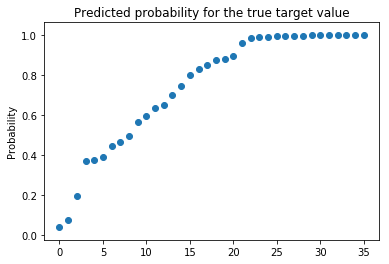

In [84]:
# Display the predicted probability for the true target value, sorted in ascending order. 
plt.scatter(range(0, probabilities.shape[0]), probabilities.probability_of_true_value.sort_values());
plt.ylabel('Probability')
plt.title('Predicted probability for the true target value');

**Result:** The logistic regression model performs better than the baseline of 33%. Most of the time, the model predicts a high or intermediate probability for the true target value, but it fails for a few statistical maps. 

## **9. Save results**

In [85]:
# Save the results into a .npz file. 
if rescale_mode == 1:
    results_file_name = 'classification_results.npz'
else:
    results_file_name = 'classification_results_r' + str(rescale_mode) + '.npz'

np.savez(results_path + results_file_name, 
         # Test scores. 
         test_score_knn = test_score_knn, 
         test_score_dt = test_score_dt, 
         test_score_rf = test_score_rf, 
         test_score_svm = test_score_svm, 
         test_score_logreg = test_score_logreg, 
         
         # Predictions. 
         y_pred_knn = y_pred_knn, 
         y_pred_dt = y_pred_dt, 
         y_pred_rf = y_pred_rf, 
         y_pred_svm = y_pred_svm, 
         y_pred_logreg = y_pred_logreg, 

         # Target. 
         y_te = y_te)